In [1]:
import uproot
import numpy as np
import awkward as ak
import math as m
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
import os
import numba as nb
import yaml
import boost_histogram as bh
from coffea import hist as chist
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema, TreeMakerSchema

import sys
import time

from coffea.util import save
from coffea.util import load

from yty_hist_class import yty_histplot

In [2]:
import xgboost as xgb
import pandas as pd 
from xgboost import XGBRegressor
from xgboost import plot_importance
from xgboost import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [43]:
out_dir = 'array_for_training'

seed = 6
test_size = 0.33

data_list_training = []
data_list_test = []
data_list = []

signal_list_training = []
signal_list_test = []
signal_list = []

# for isdata in ['data','mc']:
for isdata in ['mc']:
# for isdata in ['data']:
    nevents = 0
# for isdata in ['mc']:
# for isdata in ['data']:
#     isdata = 'data'#'data' or 'mc'
    if isdata=='data':
        Data_merge = [
                    'DoubleMuon_Run2018A','DoubleMuon_Run2018B','DoubleMuon_Run2018C','DoubleMuon_Run2018D',
                     'EGamma_Run2018A','EGamma_Run2018B','EGamma_Run2018C','EGamma_Run2018D',
                     'SingleMuon_Run2018A','SingleMuon_Run2018B','SingleMuon_Run2018C','SingleMuon_Run2018D',
                     'MuonEG_Run2018A','MuonEG_Run2018B','MuonEG_Run2018C','MuonEG_Run2018D'
                     ]
        PROCESSES= [Data_merge]

        with open(f"/data/pubfs/tyyang99/jupyter_files/data_2018_nanov7.yaml", 'r') as f:
            mc_yaml = yaml.load(f, Loader=yaml.FullLoader)
    elif isdata=='mc':
        WW_polar = ['WpWpJJ_LL_polarization_EWK','WpWpJJ_TL_polarization_EWK','WpWpJJ_TT_polarization_EWK']
        WW_merge = ['WpWpJJ_EWK', 'WpWpJJ_QCD']
        WZ_EWK = ['WLLJJ_EWK']
        WZ_merge = ['WZTo3LNu_0Jets_MLL_4to50','WZTo3LNu_1Jets_MLL_4to50','WZTo3LNu_2Jets_MLL_4to50','WZTo3LNu_3Jets_MLL_4to50',
                   'WZTo3LNu_0Jets_MLL_50','WZTo3LNu_1Jets_MLL_50','WZTo3LNu_2Jets_MLL_50','WZTo3LNu_3Jets_MLL_50']
        ZZ_merge = ['ZZJJTo4L_EWK','ZZJJTo4L_QCD','ZZJJTo4L_int','ggZZ_2e2mu',
                   'ggZZ_2e2tau','ggZZ_2mu2tau','ggZZ_4e','ggZZ_4mu','ggZZ_4tau','ggZZ_4tau_ext']
        TVX_merge = ['TTGJets','TTZToQQ','TTZToQQ_ext','TTZToLLNuNu_M_10',
                     'TTWJetsToQQ','TTWJetsToLNu','tZq']
        VG_merge = ['Zgamma_EWK','Zgamma_EWK_ext','Wgamma_EWK','Wgamma_int']
        WS_merge = ['WWTo2L2Nu',
                    'ggWW_ee','ggWW_em','ggWW_et','ggWW_me','ggWW_mm','ggWW_mt','ggWW_te','ggWW_tm','ggWW_tt',
                    'TTTo2L2Nu','ST_tW_top','ST_tW_antitop',
                    'DYJetsToLL_M50','DYJets_M10to50','DYJets_M10to50_ext','ggh_ww','ggh_zz','ggh_tautau',
                    'VBF_HToZZTo4L','VBFHToWWTo2L2Nu','VBFHToTauTau',
                    'ttHToNonbb','VHToNonbb']
        Other_merge = ['WW_DS','WWW','WWZ','WZZ','ZZZ','WWG']

#         PROCESSES = [WW_polar, WW_merge, WZ_EWK, WZ_merge, ZZ_merge, TVX_merge, VG_merge, WS_merge, Other_merge]
        PROCESSES = [WW_polar]
#         PROCESSES = [WS_merge]
        with open(f"/data/pubfs/tyyang99/jupyter_files/changexs_datasets.yaml", 'r') as f:
            mc_yaml = yaml.load(f, Loader=yaml.FullLoader)
    else:
        print('!!!Wrong data type!!!')
    for i,process_list in enumerate(PROCESSES):
        for process in process_list:
            if process.endswith('_ext') or process=='WpWpJJ_EWK':
                continue
            else:
                try:
                    arrays = ak.from_parquet(f'{out_dir}/{process}.parquet')
                except:
                    print(f'{process} no events')
                    continue
                print(process, len(arrays), np.sum(arrays['weight'])/len(arrays))
                if process=='WpWpJJ_LL_polarization_EWK':
                    signal = ak.ones_like(arrays['weight'])
                else:
                    signal = ak.zeros_like(arrays['weight'])
                try:
                    arrays_training, arrays_test, signal_training, signal_test = train_test_split(arrays, signal, test_size=test_size, train_size=(1-test_size), random_state=seed)
                except:
                    arrays_training, arrays_test, signal_training, signal_test = arrays, [], signal, []
                data_list_training.append(arrays_training)
                data_list_test.append(arrays_test)
                data_list.append(arrays)
                
                signal_list_training.append(signal_training)
                signal_list_test.append(signal_test)
                signal_list.append(signal)
                
    All_data_training = ak.concatenate(data_list_training)
    All_data_test = ak.concatenate(data_list_test)
    All_data = ak.concatenate(data_list)
    
    All_data_training['signal'] = ak.concatenate(signal_list_training)
    All_data_test['signal'] = ak.concatenate(signal_list_test)
    All_data['signal'] = ak.concatenate(signal_list)
    
    weight_boost_training = np.sum(All_data_training['weight'][All_data_training['signal']==0])/np.sum(All_data_training['weight'][All_data_training['signal']==1])
    All_data_training['training_weight'] = 1*(All_data_training['signal']==0)*All_data_training['weight'] + weight_boost_training*(All_data_training['signal']==1)*(All_data_training['weight'])
    pd_data_training = ak.to_pandas(All_data_training)
    pd_data_test = ak.to_pandas(All_data_test)

WpWpJJ_LL_polarization_EWK 120203 6.833796911618149e-05
WpWpJJ_TL_polarization_EWK 135344 0.00032310943003734636
WpWpJJ_TT_polarization_EWK 155934 0.0004806294468683465


In [4]:
np.sum(All_data_training['signal']==1)

80536

In [5]:
pd_data_training

,Lepton_pt1,Lepton_pt2,Lepton_eta1,Lepton_eta2,Lepton_phi1,Lepton_phi2,detall,dphill,drll,mll,...,njets,lepton_channel,dphillmet,dphijjmet,detajjll,dphijjll,drjjll,weight,signal,training_weight
entry,,,,,,,,,,,,,,,,,,,,,
0,66.361275,35.249584,0.557617,0.405090,-1.475342,1.708740,0.152527,3.099103,3.102855,96.990639,...,4.0,2,0.524414,2.942574,4.904295,2.418160,5.468053,0.000068,1.0,0.000987
1,78.232910,60.490791,-1.516846,-0.887939,0.397400,0.265442,0.628906,0.131958,0.642601,44.906761,...,2.0,2,1.481845,2.080593,2.522696,2.720748,3.710318,0.000067,1.0,0.000970
2,38.897736,34.598541,-1.728760,2.288574,1.728516,2.423828,4.017334,0.695312,4.077062,269.667786,...,3.0,3,2.836153,0.156220,3.389467,2.992373,4.521370,0.000068,1.0,0.000982
3,50.479313,49.014099,-2.257812,-2.116699,-0.508789,1.626953,0.141113,2.135742,2.140399,87.446945,...,2.0,3,0.235018,2.775282,0.663109,3.010300,3.082470,0.000069,1.0,0.001000
4,51.088097,46.392658,1.355713,-0.946411,2.311523,1.459473,2.302124,0.852051,2.454744,144.243530,...,2.0,3,2.685988,1.227949,0.523279,2.369248,2.426346,0.000069,1.0,0.000995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275686,33.087517,30.696081,-1.749512,2.022949,2.614258,-1.492188,3.772461,2.176740,4.355417,212.950958,...,4.0,3,2.438996,1.547960,4.033297,0.891036,4.130548,0.000480,0.0,0.000480
275687,108.926613,58.044678,-0.485291,-1.646729,-0.871704,0.993774,1.161438,1.865479,2.197487,160.777985,...,3.0,1,1.958735,2.399154,0.870256,1.925297,2.112845,0.000479,0.0,0.000479
275688,151.718369,77.525177,-0.781494,-1.715088,2.402832,-0.742188,0.933594,3.138166,3.274093,240.969162,...,2.0,1,1.465215,2.297918,6.560033,2.520052,7.027425,0.000479,0.0,0.000479


In [27]:
x_vars = All_data_training.fields[:-3]
X_train = pd_data_training[x_vars]
y_train = pd_data_training['signal']
sample_weight = abs(pd_data_training['training_weight'])
lr = 0.3
#model = XGBRegressor(n_estimators=600, learning_rate=lr, max_depth=6, gamma=2)
model = XGBRegressor(n_estimators=400, learning_rate=lr, max_depth=3)
#model.fit(X_train, all_y_train, sample_weight = all_w_train*Lumi)
model.fit(X_train, y_train, sample_weight = sample_weight)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

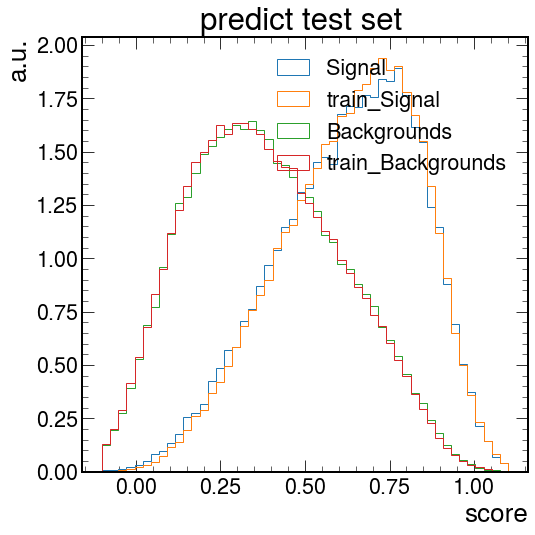

In [28]:
X_test = pd_data_test[x_vars]
y_test = pd_data_test['signal']
y_pred = model.predict(X_test)

test_signal = X_test[y_test == 1]
train_signal = X_train[y_train == 1]
test_bg = X_test[y_test == 0]
train_bg = X_train[y_train == 0]

pred_signal_all = model.predict(test_signal)
pred_train_signal_all = model.predict(train_signal)
pred_bg_all = model.predict(test_bg)
pred_train_bg_all = model.predict(train_bg)

# Bins = np.linspace(-0.25,1.25,50+1)
Bins = np.linspace(-0.1,1.1,50+1)
plt.figure(figsize=(8,8))
plt.hist(pred_signal_all,bins=Bins,histtype="step",label="Signal",density = True)
plt.hist(pred_train_signal_all,bins=Bins,histtype="step",label="train_Signal",density = True)
# plt.hist(pred_top,bins=Bins,histtype="step",label="Top_Test",density = True)
plt.hist(pred_bg_all,bins=Bins,histtype="step",label="Backgrounds",density = True)
plt.hist(pred_train_bg_all,bins=Bins,histtype="step",label="train_Backgrounds",density = True)
# plt.hist(pred_wbj,bins=Bins,histtype="step",label="WBJets_Test",density = True)
plt.title('predict test set ')
plt.xlabel('score')
plt.ylabel('a.u.')
plt.legend()

In [29]:
All_data_training.fields

['Lepton_pt1',
 'Lepton_pt2',
 'Lepton_eta1',
 'Lepton_eta2',
 'Lepton_phi1',
 'Lepton_phi2',
 'detall',
 'dphill',
 'drll',
 'mll',
 'ptll',
 'Jet_pt1',
 'Jet_pt2',
 'Jet_eta1',
 'Jet_eta2',
 'Jet_phi1',
 'Jet_phi2',
 'detajj',
 'dphijj',
 'drjj',
 'mjj',
 'ptjj',
 'MET_pt',
 'MET_phi',
 'zlep1',
 'zlep2',
 'njets',
 'lepton_channel',
 'dphillmet',
 'dphijjmet',
 'detajjll',
 'dphijjll',
 'drjjll',
 'weight',
 'signal',
 'training_weight']

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

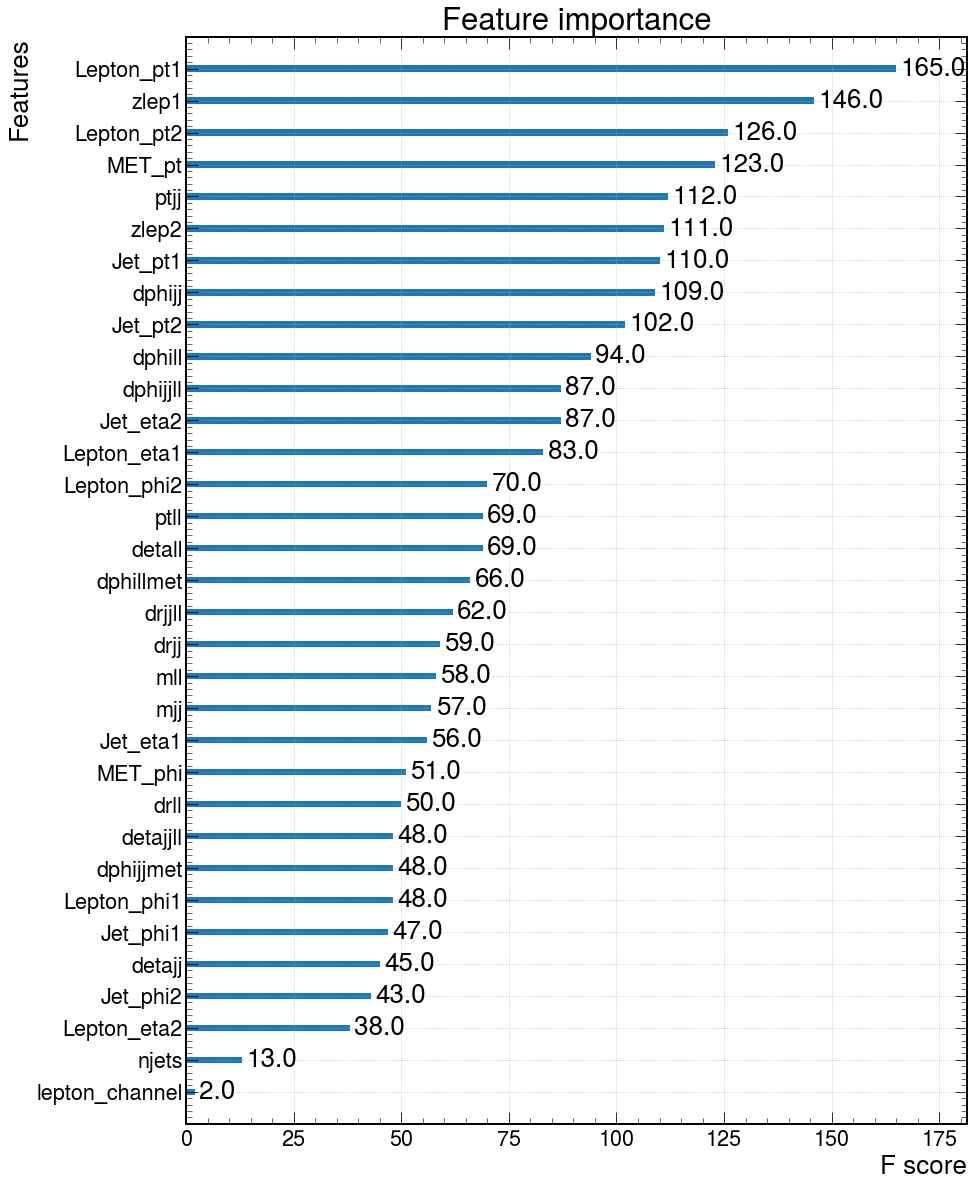

In [30]:
mpl.style.use(hep.style.CMS)
plt.figure(figsize = (14,20))
ax = plt.subplot(111)
plot_importance(model,ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

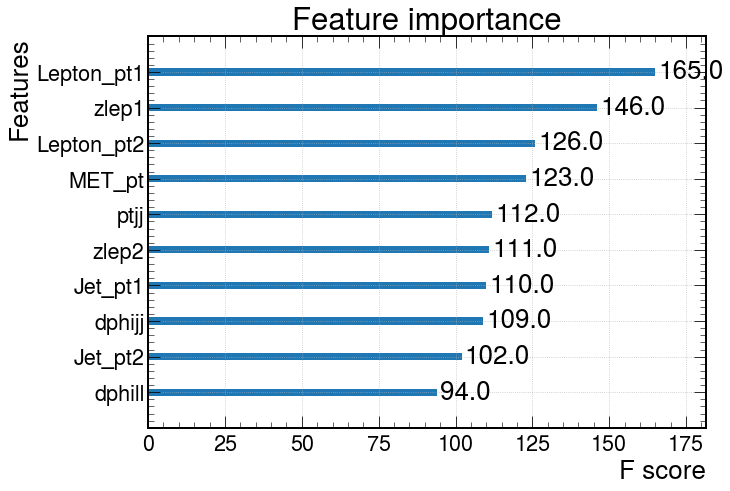

In [60]:
# plt.figure(figsize = (15,15))
plt.figure(figsize = (10,7.2))
ax = plt.subplot(111)
plot_importance(model,ax=ax,max_num_features=10)
# plot_importance(model,ax=ax)

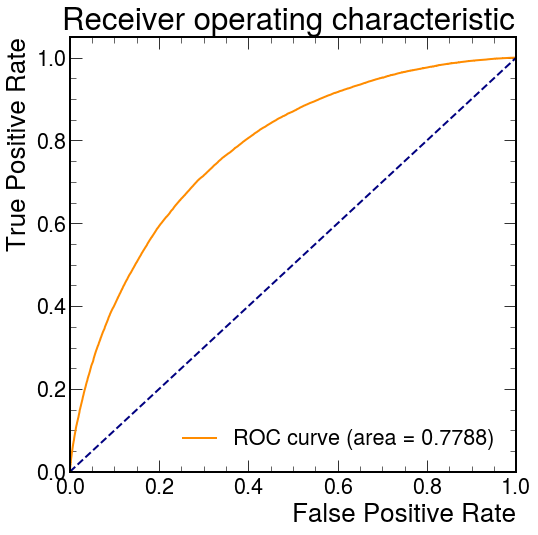

In [31]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test[:], y_pred[:])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")

Create type 1 hist_plot named "BDT_score".
draw  test_sg
draw  test_bg
draw  train_sg
draw  train_bg


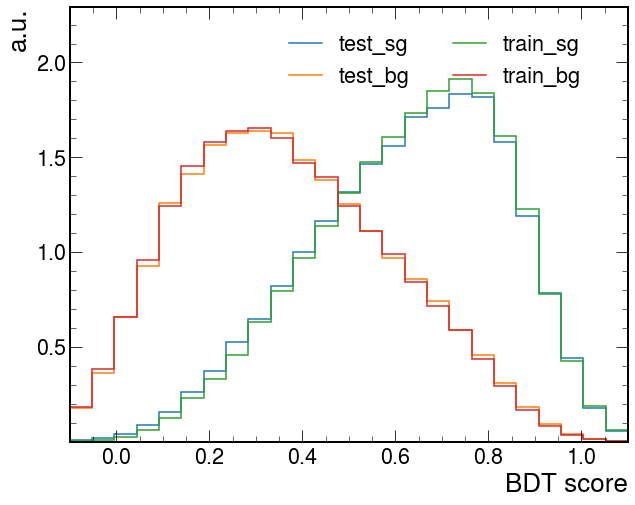

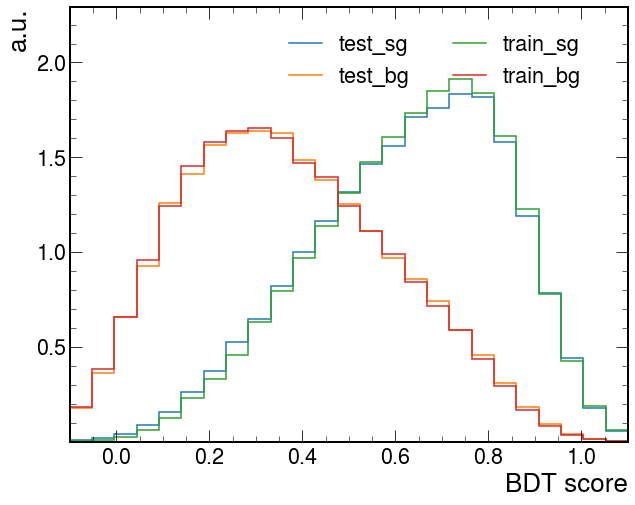

In [32]:
from scipy.stats import chisquare
from scipy.stats import kstest
from scipy.stats import ks_2samp

mpl.style.use(hep.style.CMS)

y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]

# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
# plot_importance(model, importance_type='gain')


test_sg = X_test[y_test == 1]
train_sg = X_train[y_train == 1]
test_bg = X_test[y_test == 0]
train_bg = X_train[y_train == 0]

pred_test_sg = model.predict(test_sg)
pred_train_sg = model.predict(train_sg)
pred_test_bg = model.predict(test_bg)
pred_train_bg = model.predict(train_bg)

weight_test_sg = pd_data_test[y_test == 1]['weight']
weight_test_bg = pd_data_test[y_test == 0]['weight']
weight_train_sg = pd_data_training[y_train == 1]['weight']
weight_train_bg = pd_data_training[y_train == 0]['weight']

Bins = np.linspace(-0.1,1.1,25+1)
BDT_score_hist = yty_histplot('BDT_score',1,Bins,Figsize=(10,8))

BDT_score_hist.append_values('test_sg', [pred_test_sg])
BDT_score_hist.append_weights('test_sg', [weight_test_sg/np.sum(weight_test_sg)])
BDT_score_hist.append_values('test_bg', [pred_test_bg])
BDT_score_hist.append_weights('test_bg', [weight_test_bg/np.sum(weight_test_bg)])
BDT_score_hist.append_values('train_sg', [pred_train_sg])
BDT_score_hist.append_weights('train_sg', [weight_train_sg/np.sum(weight_train_sg)])
BDT_score_hist.append_values('train_bg', [pred_train_bg])
BDT_score_hist.append_weights('train_bg', [weight_train_bg/np.sum(weight_train_bg)])

BDT_score_hist.set_title(Lumi=None, Year=None, xlabel='BDT score', y1label='a.u.', title='',cmstitle=False)
BDT_score_hist.set_legend(legendbool=True,ncol=2)
BDT_score_hist.set_autoylim(1.2)
BDT_score_hist.draw()

In [38]:
cut_scan = np.linspace(0,1,100+1)
scan_list = []
# cut_scan = np.linspace(0,0.95,20)
# cut_scan = np.linspace(0,0.90,19)
significance_simple = []
significance_za = []
for cut in cut_scan:
    b = 1/test_size*np.sum(pd_data_test[y_test == 0][pred_test_bg>cut]['weight'])
    s = 1/test_size*np.sum(pd_data_test[y_test == 1][pred_test_sg>cut]['weight'])
    print('cut: %.2f\ts; %.3f\tb: %.3f'%(cut, s, b))
    if b==0:
        b = 1e-5
    significance_simple.append(s/np.sqrt(b))
    significance_za.append(np.sqrt(2)*np.sqrt((s + b)*np.log(1+s/b) - s))
    scan_list.append(cut)
    if s==0 or b==0:
        break

cut: 0.00	s; 8.203	b: 114.808
cut: 0.01	s; 8.200	b: 114.198
cut: 0.02	s; 8.197	b: 113.443
cut: 0.03	s; 8.194	b: 112.599
cut: 0.04	s; 8.188	b: 111.698
cut: 0.05	s; 8.183	b: 110.759
cut: 0.06	s; 8.175	b: 109.781
cut: 0.07	s; 8.169	b: 108.748
cut: 0.08	s; 8.163	b: 107.551
cut: 0.09	s; 8.154	b: 106.300
cut: 0.10	s; 8.145	b: 104.935
cut: 0.11	s; 8.133	b: 103.534
cut: 0.12	s; 8.118	b: 102.044
cut: 0.13	s; 8.105	b: 100.472
cut: 0.14	s; 8.090	b: 98.887
cut: 0.15	s; 8.073	b: 97.280
cut: 0.16	s; 8.051	b: 95.656
cut: 0.17	s; 8.029	b: 93.951
cut: 0.18	s; 8.005	b: 92.261
cut: 0.19	s; 7.981	b: 90.483
cut: 0.20	s; 7.958	b: 88.693
cut: 0.21	s; 7.930	b: 86.870
cut: 0.22	s; 7.898	b: 85.023
cut: 0.23	s; 7.864	b: 83.123
cut: 0.24	s; 7.821	b: 81.220
cut: 0.25	s; 7.786	b: 79.238
cut: 0.26	s; 7.743	b: 77.343
cut: 0.27	s; 7.696	b: 75.402
cut: 0.28	s; 7.652	b: 73.472
cut: 0.29	s; 7.602	b: 71.520
cut: 0.30	s; 7.554	b: 69.514
cut: 0.31	s; 7.506	b: 67.582
cut: 0.32	s; 7.447	b: 65.618
cut: 0.33	s; 7.391	b: 63.729


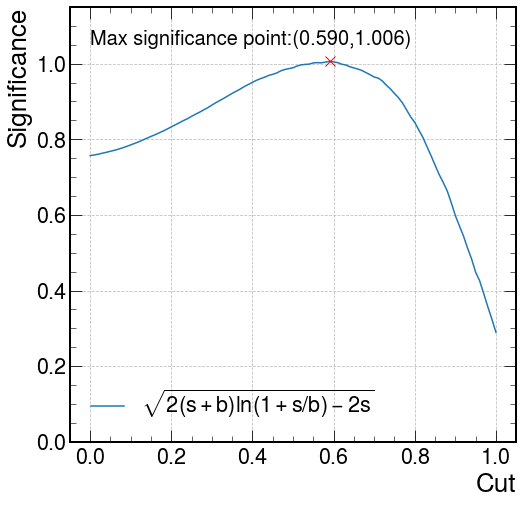

In [42]:
plt.figure(figsize=(8,8))
# plt.plot(cut_scan,significance_simple,label = r"$s/\sqrt{b}$")
plt.plot(scan_list,significance_za,label = "$\sqrt{2(s+b)ln(1+s/b) - 2s}$")
threshold,Max_sig = max(significance_za),np.argmax(significance_za)*0.01
plt.plot(Max_sig,threshold,'rx',markersize=10)
plt.ylim(0,1.15)
plt.xlabel('Cut')
plt.ylabel('Significance')
plt.grid(linestyle='--')
plt.text(0,1.05,'Max significance point:(%.3f,%.3f)'%(Max_sig,threshold),fontsize=20)
plt.legend()

In [10]:
len(All_data_training.fields)

36

Lepton_pt1
Create type 1 hist_plot named "Lepton_pt1_distribution".
Lepton_pt2
Create type 1 hist_plot named "Lepton_pt2_distribution".
Lepton_eta1
Create type 1 hist_plot named "Lepton_eta1_distribution".
Lepton_eta2
Create type 1 hist_plot named "Lepton_eta2_distribution".
Lepton_phi1
Create type 1 hist_plot named "Lepton_phi1_distribution".
Lepton_phi2
Create type 1 hist_plot named "Lepton_phi2_distribution".
detall
Create type 1 hist_plot named "detall_distribution".
dphill
Create type 1 hist_plot named "dphill_distribution".
drll
Create type 1 hist_plot named "drll_distribution".
mll
Create type 1 hist_plot named "mll_distribution".
ptll
Create type 1 hist_plot named "ptll_distribution".
Jet_pt1
Create type 1 hist_plot named "Jet_pt1_distribution".
Jet_pt2
Create type 1 hist_plot named "Jet_pt2_distribution".
Jet_eta1
Create type 1 hist_plot named "Jet_eta1_distribution".
Jet_eta2
Create type 1 hist_plot named "Jet_eta2_distribution".
Jet_phi1
Create type 1 hist_plot named "Jet_ph

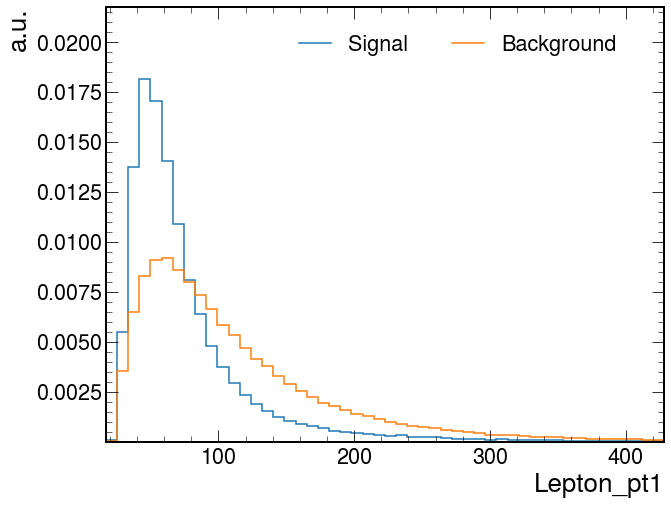

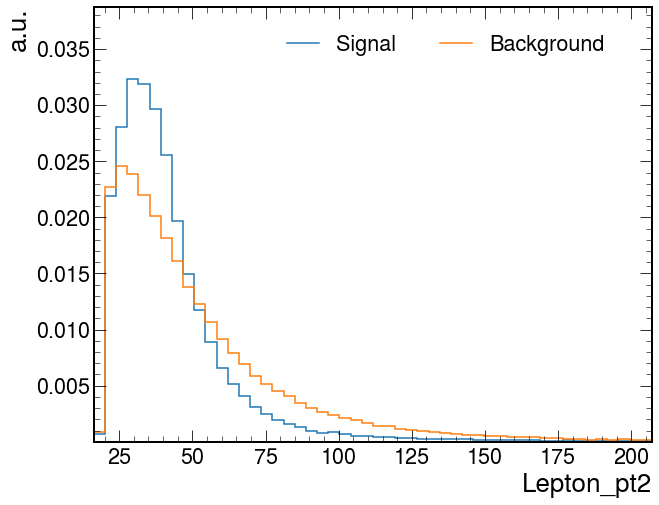

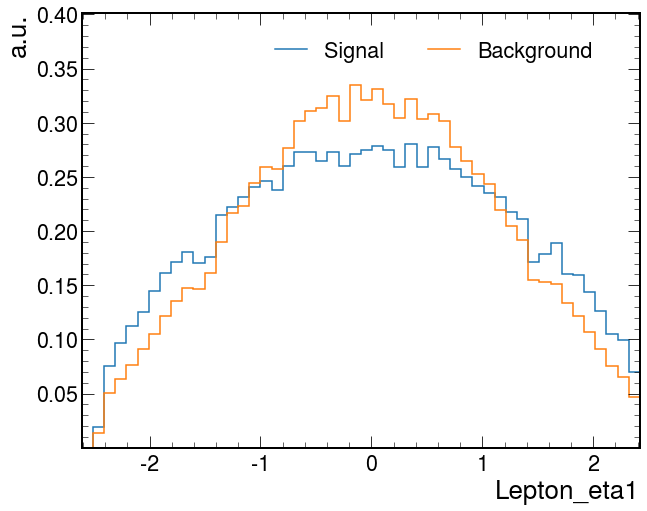

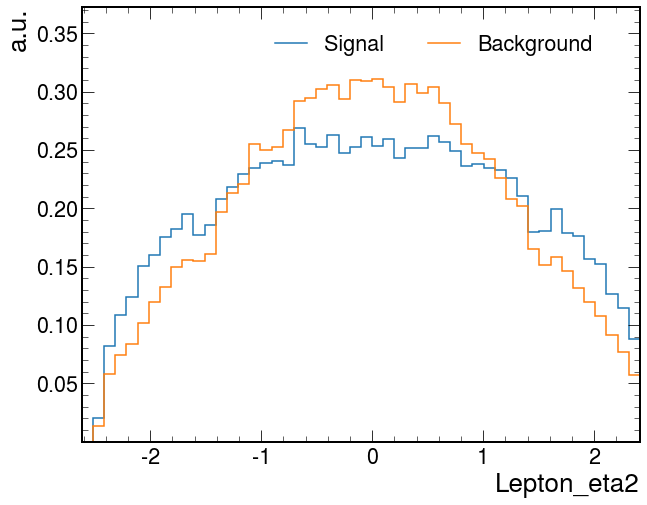

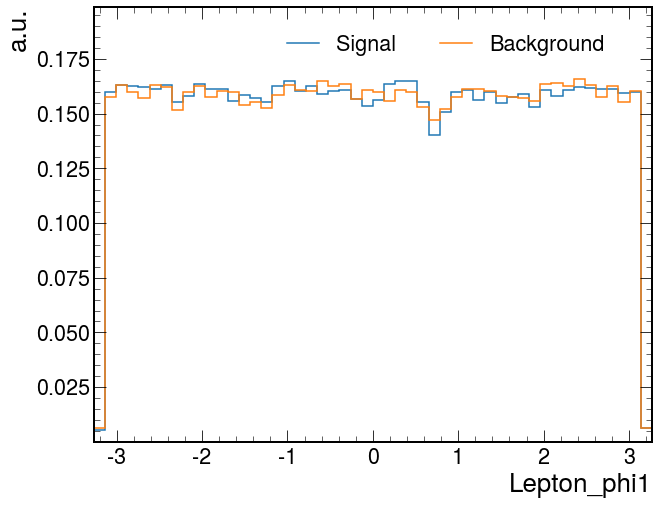

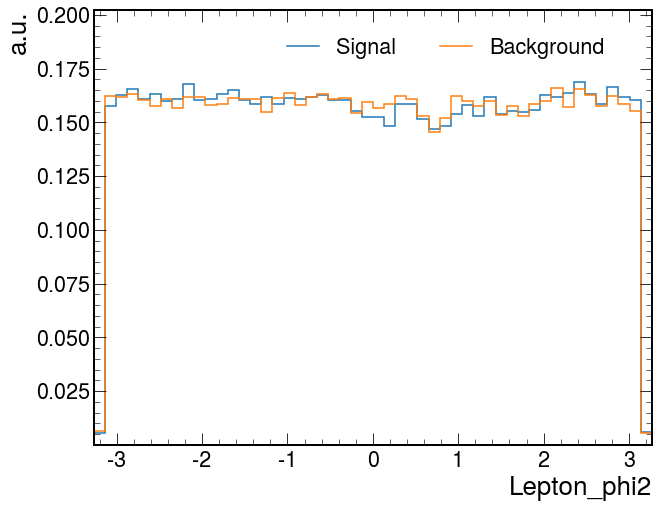

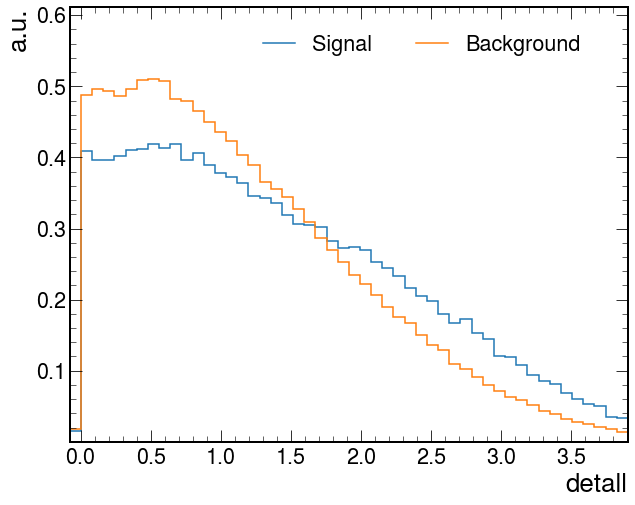

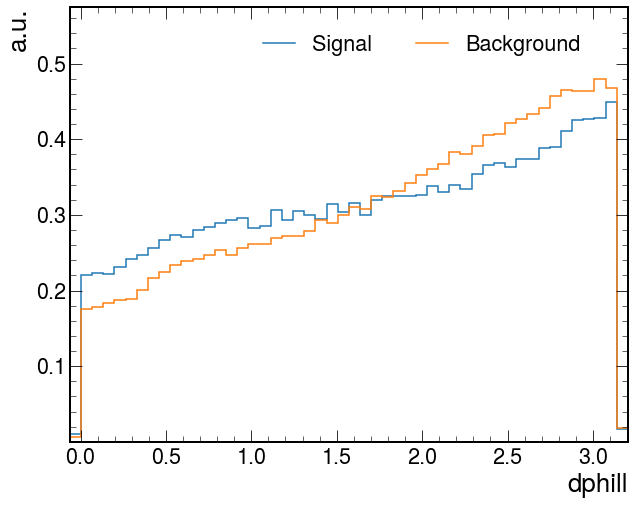

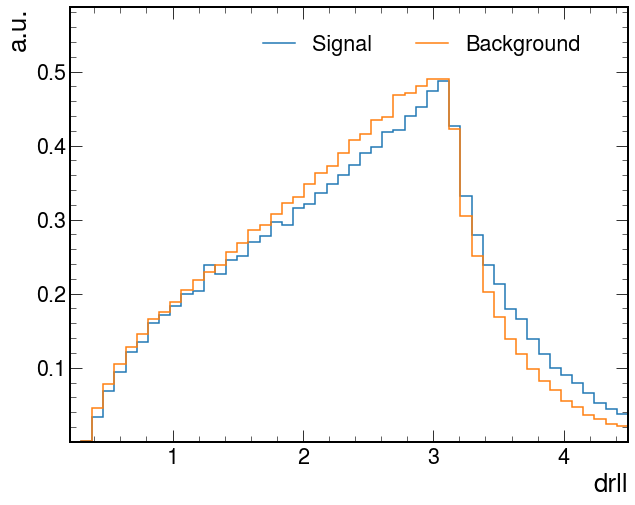

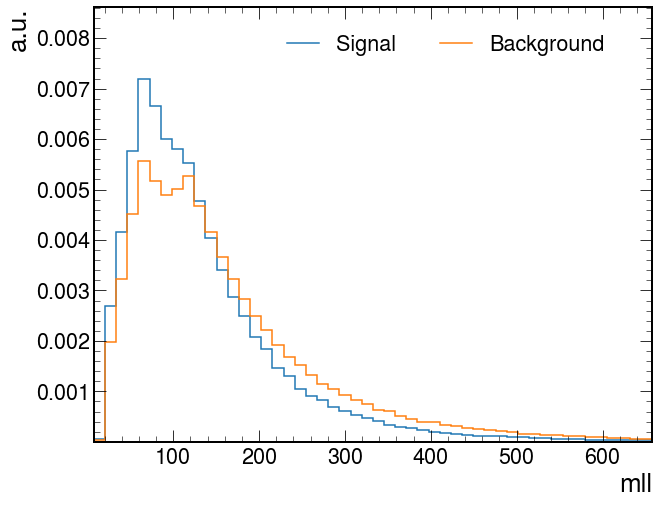

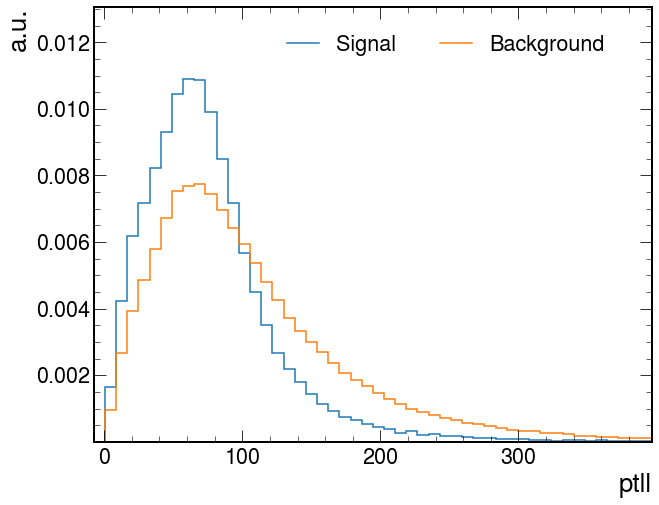

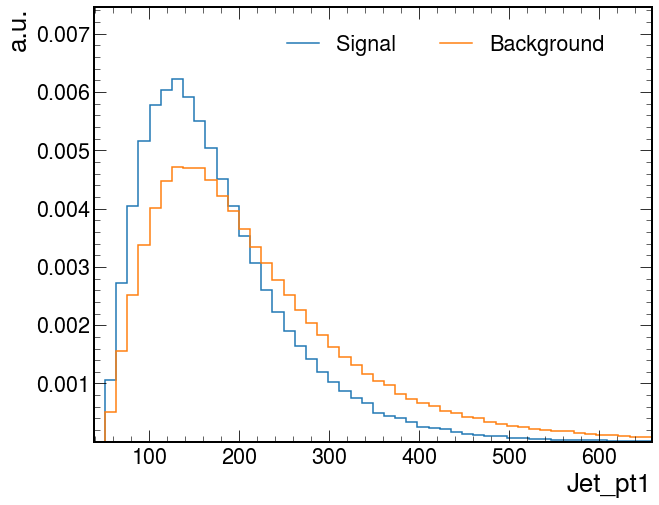

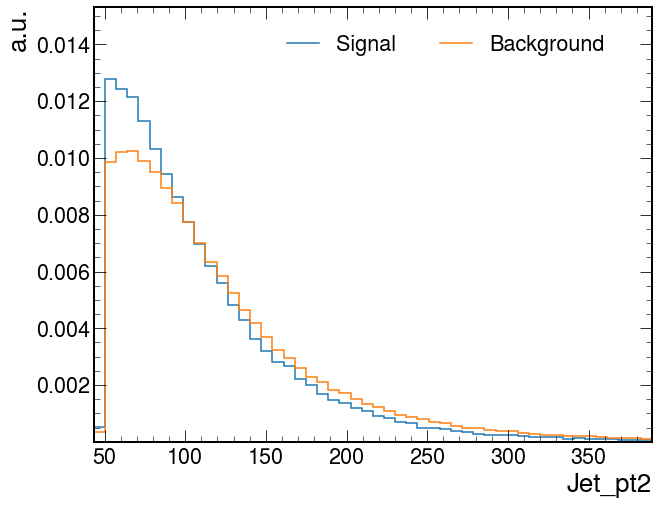

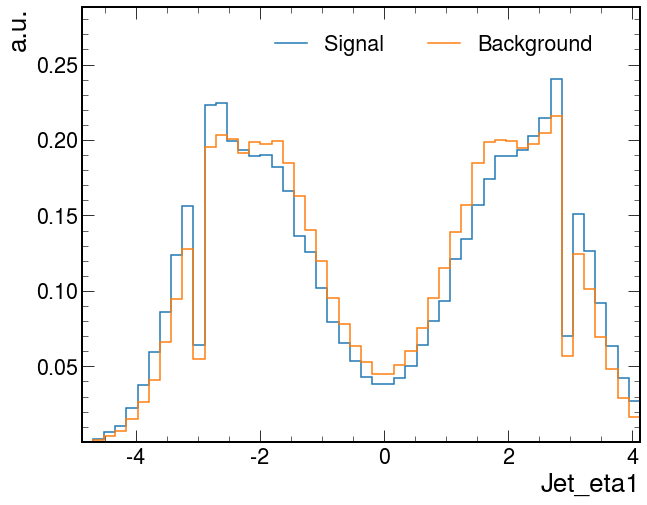

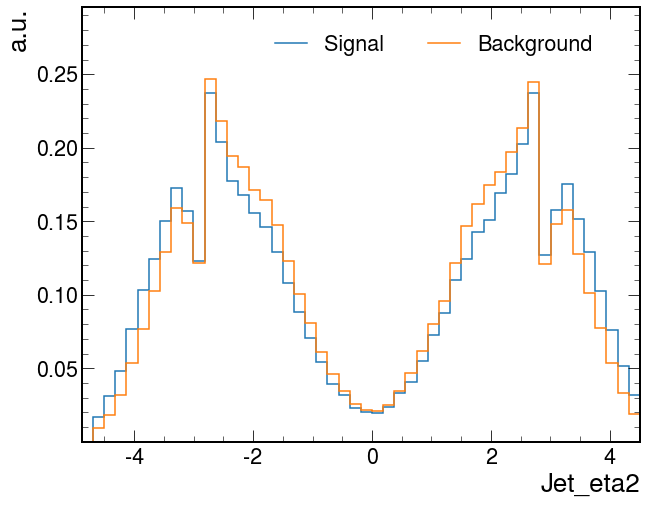

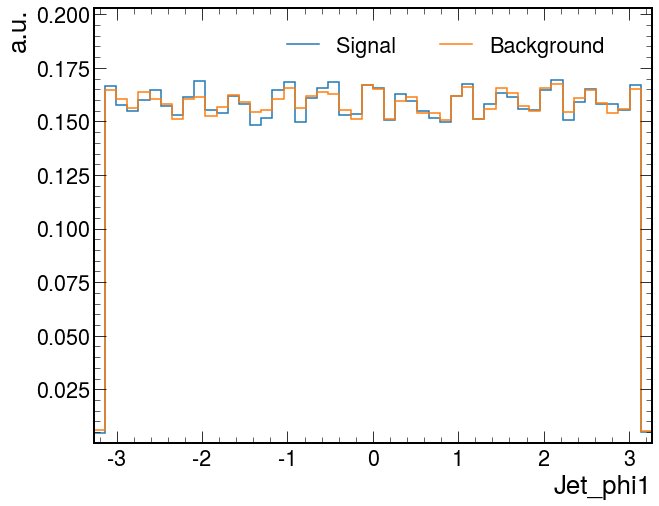

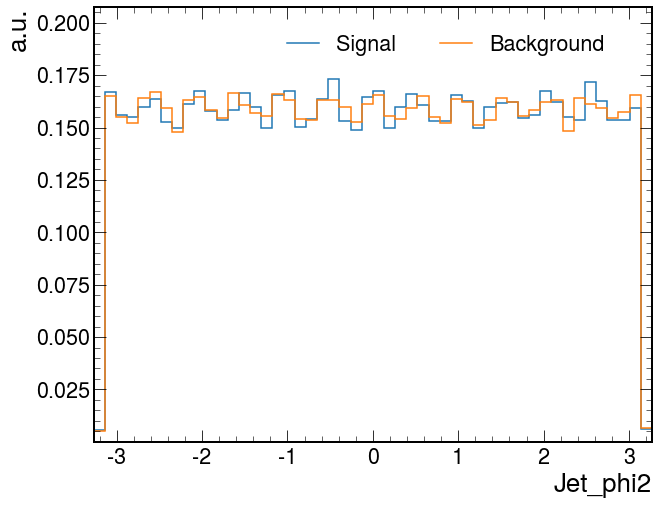

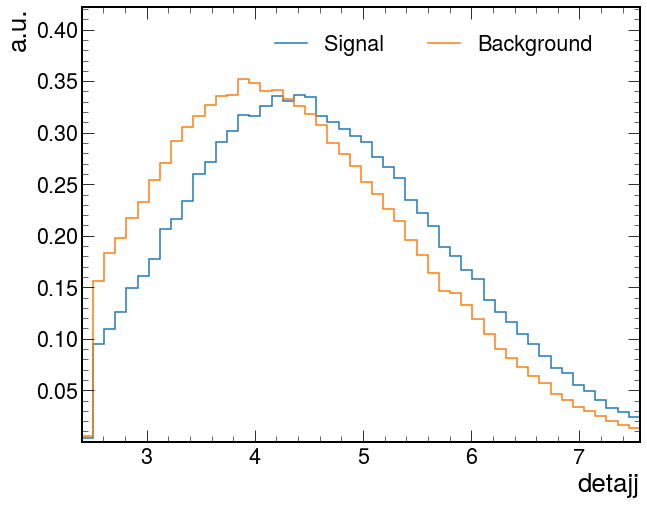

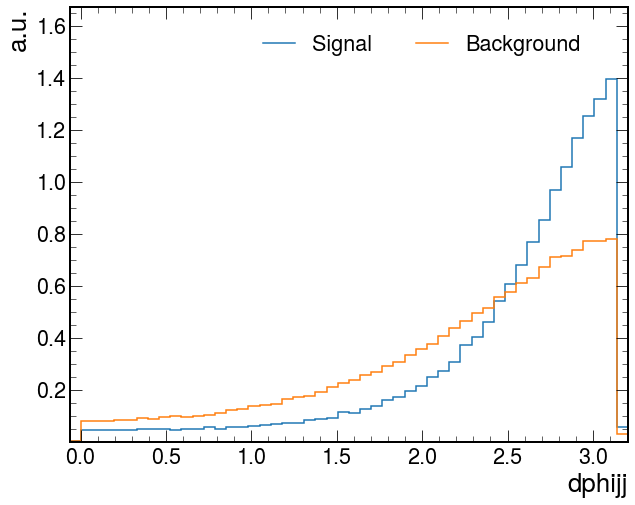

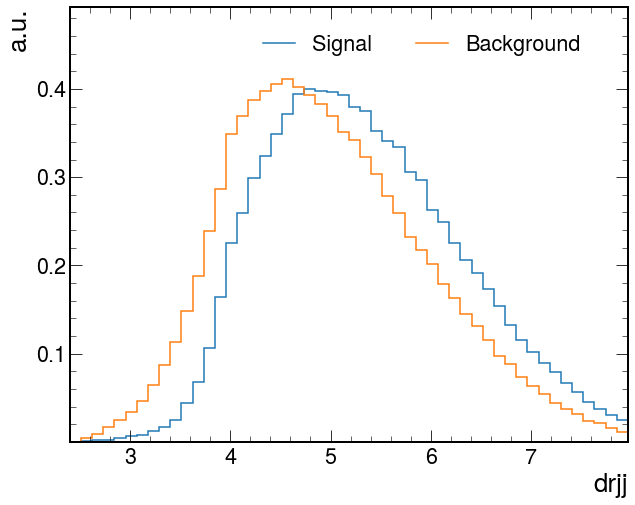

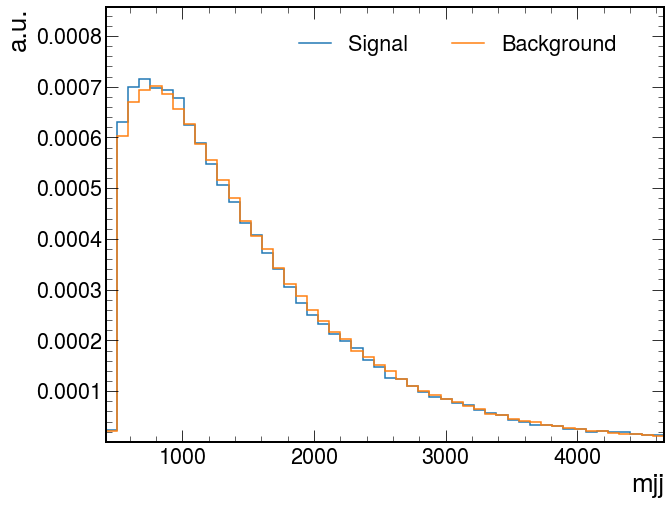

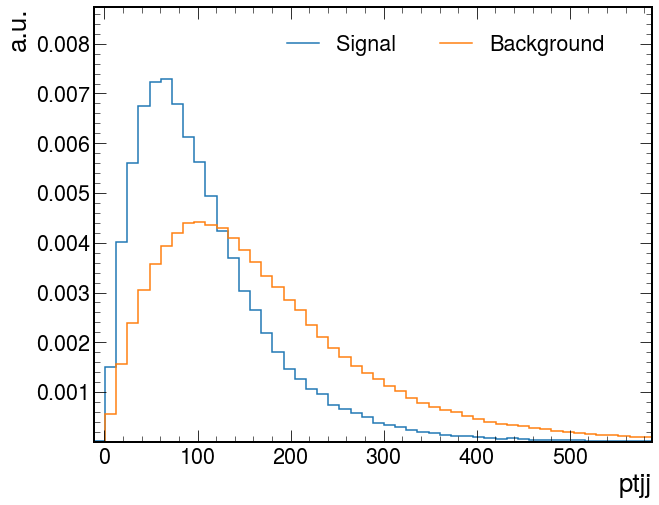

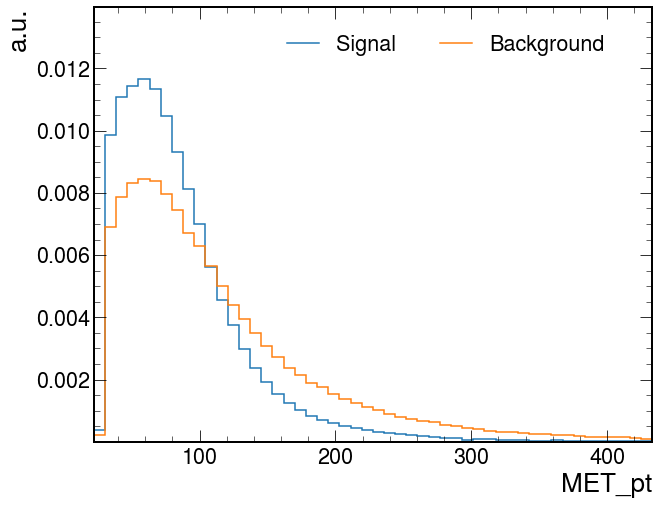

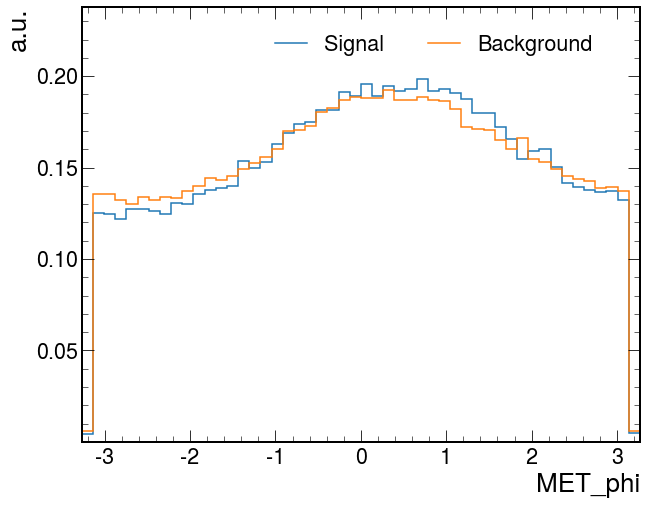

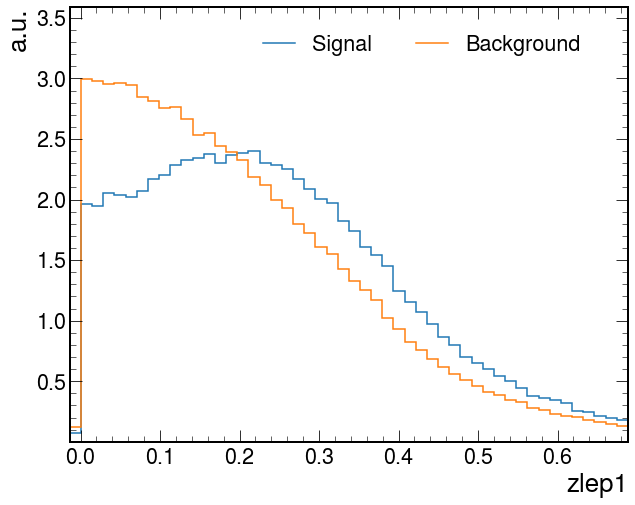

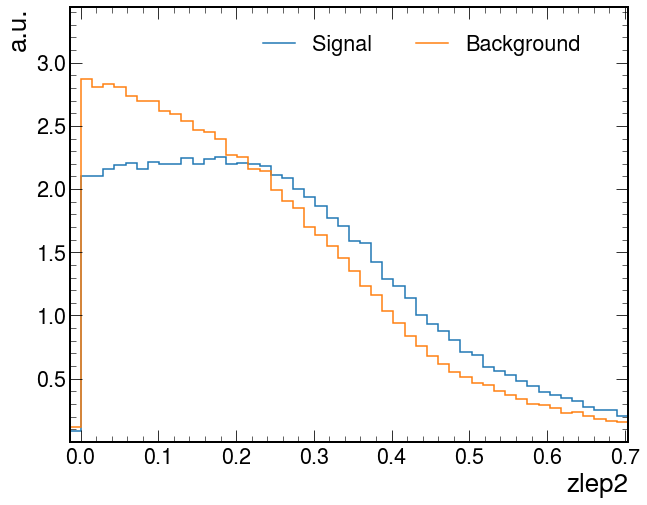

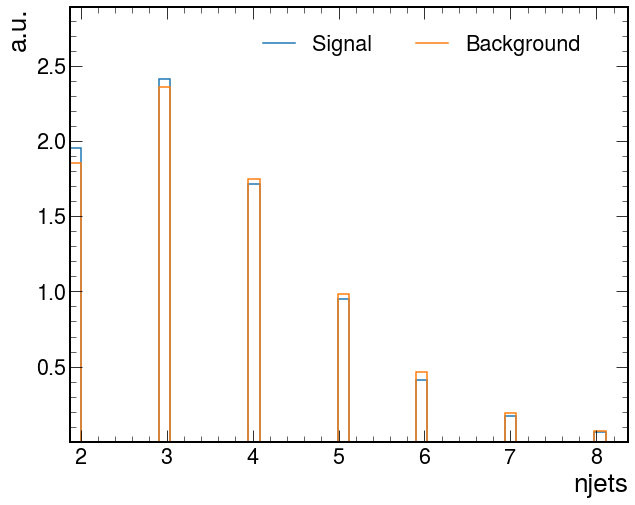

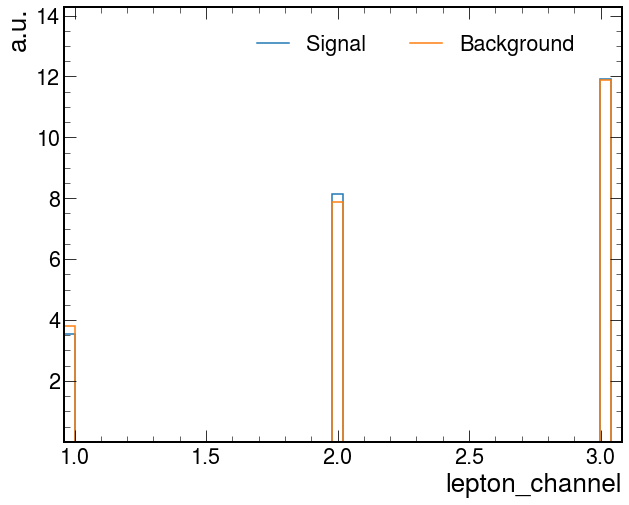

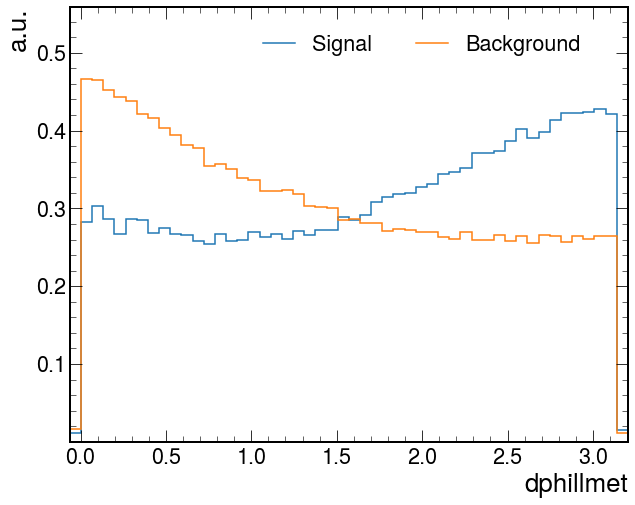

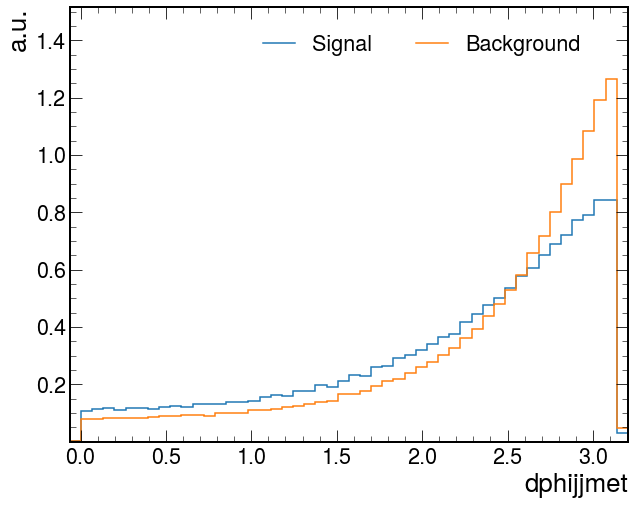

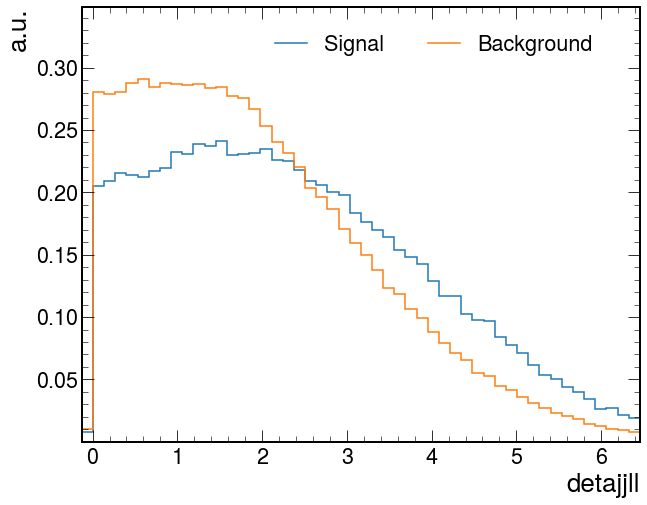

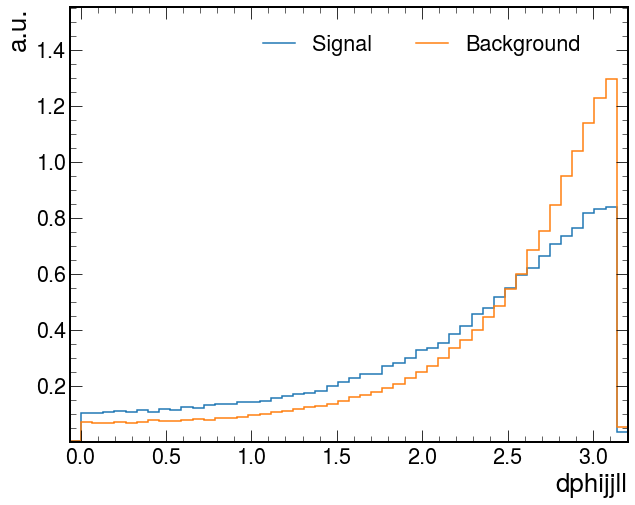

In [62]:
#multivariate analysis 

hist_list = []
for var_name in All_data.fields[:-3]:
    print(var_name)
    var_array = All_data[var_name]
    weight_array = All_data['weight']
    
    weight_sg = weight_array[All_data['signal']==1]
    weight_bg = weight_array[All_data['signal']==0]
    
    min_value, max_value = min(var_array), max(var_array)
    step = (max_value-min_value)/50
    
    while np.sum(var_array<max_value)/len(var_array)>=0.99:
#         print(max_value,np.sum(var_array<max_value)/len(var_array))
        max_value -= step
    max_value += step
    
    new_step = (max_value-min_value)/50
    bins = np.linspace(min_value-new_step,max_value+new_step,50+1)
    
    dis_hist = yty_histplot(f'{var_name}_distribution',1,bins,Figsize=(10,8))
    
    dis_hist.append_values('Signal', [var_array[All_data['signal']==1]])
    dis_hist.append_weights('Signal', [weight_sg/np.sum(weight_sg)])
    
    dis_hist.append_values('Background', [var_array[All_data['signal']==0]])
    dis_hist.append_weights('Background', [weight_bg/np.sum(weight_bg)])
    dis_hist.set_title(Lumi=None, Year=None, xlabel=var_name, y1label='a.u.', title='',cmstitle=False)
    dis_hist.set_legend(legendbool=True,ncol=2)
    dis_hist.set_autoylim(1.2)
    
    hist_list.append(dis_hist)
    
for ihist in hist_list:
    ihist.draw()

In [45]:
min_value

25.00221824645996

In [46]:
max_value

1671.541748046875